### Genetic Algorithm 
- uses energy efficiency dataset https://archive.ics.uci.edu/ml/datasets/energy+efficiency#


We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.


Attribute Information:

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses. 

Specifically: 
- X1	Relative Compactness 
- X2	Surface Area 
- X3	Wall Area 
- X4	Roof Area 
- X5	Overall Height 
- X6	Orientation 
- X7	Glazing Area 
- X8	Glazing Area Distribution 
- y1	Heating Load 
- y2	Cooling Load



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Get the dataset
- df.sample(frac=1) shuffles the data 

In [2]:
df = pd.read_csv("energy_efficiency.csv")
df = df.sample(frac=1)
rows = len(df)
cols = len(df.keys())
print(rows, cols)
df.head()

768 10


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
705,0.69,735.0,294.0,220.5,3.5,3,0.40,4,14.62,16.88
742,0.76,661.5,416.5,122.5,7.0,4,0.40,5,39.31,37.79
182,0.66,759.5,318.5,220.5,3.5,4,0.10,3,11.53,13.59
188,0.62,808.5,367.5,220.5,3.5,2,0.10,3,12.68,14.09
522,0.64,784.0,343.0,220.5,3.5,4,0.25,5,16.76,20.19


### X6 and X8 are categorical variables

In [3]:
X = pd.get_dummies(df.iloc[:,0:(cols-2)], columns=['X6', 'X8']).values
y = df.iloc[:, (cols-2):(cols-1)].values
print(X[0])
print(y[0])

[6.900e-01 7.350e+02 2.940e+02 2.205e+02 3.500e+00 4.000e-01 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00]
[14.62]


### Scale the data with minmax scaler

In [4]:
mms = preprocessing.MinMaxScaler()
X = mms.fit_transform(X)
print(X[0])

[0.19444444 0.75       0.28571429 1.         0.         1.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.        ]


### Set genetic algorithm parameters
- M : number of generations
- N : population size
- Pc: probability of crossover
- Pm: probability of mutation
- l : string size
- k : tournament selection contestants

### **since we are performing a GA for SVM, the parameters to tune are c and gamma**

#### SVM hyperparameters
- kernel: poly, rbf, linear
- poly: degree of polynomial
- c: controls the tradeoff between low error and maximizing the norm of the weight
- gamma: determines strength of training sample with gaussian kernel

In [5]:
#probability of crossover
Pc = .95 #these do not need to sum to 1
#probability of mutation
Pm = .12
#size of population
pop = 12
#number of generations
gen = 24
l = 24 # first 12 are for c, second 12 are for gamma

In [6]:
# the chromosome
xy = np.random.choice([0,1], size=(l,), p=[.5, .5])
print(xy)

[1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1]


### Create a random population of chromosomes (potential solutions)

In [7]:
population = np.empty((0, len(xy)))
for i in range(gen):
    random.shuffle(xy)
    population = np.vstack((population, xy))

In [8]:
print(population[0:5])

[[0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.]]


### Calculate precision of the chromosomes
- Range (a,b)
- length, l
- precision (b-a)/(2^l-1)
- encode (literal base 2 encoding)
- decode (sum(bit*2^i)*precision + a

In [9]:
# parameter c, see precision formula
ac = 10
bc = 1000
lc = len(xy)/2
pc = (bc - ac)/((2**lc)-1)

In [10]:
# parameter gamma, see precision formula
ag = .05
bg = .99
lg = len(xy)/2
pg = (bg - ag)/((2**lg)-1)

### Functions

In [11]:
def decode(xy, index, precision, lowerBound):
    """Decodes a chromosome into a real value"""
    power = 0 #binary powers
    sum = 0
    for i in range(len(xy)//2):
        val = xy[index]*(2**power)
        sum += val
        index -= 1
        power += 1
    return (sum * precision) + lowerBound

def kfold(choice, num_folds):
    c = decode(choice, cIndex, pc, ac)
    g = decode(choice, gIndex, pg, ag)
    total = 0
    kf = cross_validation.KFold(len(X),n_folds=num_folds)

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = svm.SVR(kernel='rbf',C=c, gamma=g)
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        err = 1-acc
        total += err
    #need the total error
    total = total/num_folds
    return total

def parentSelection(population, l):
    """
    returns two parents from a population given the chromosome size l
    """
    parents = np.zeros((0, l))
    for k in range(2):
        #get some random samples to pick good parents
        candidates = population[np.random.choice(len(population), 3, replace=False)]

        #the best selection for a parent
        selection = -1
        score = 10000000

        for choice in candidates:
            #c and gamma values for SVR
            total = kfold(choice, num_folds)
            #print(total)
            if (total < score):
                score = total
                selection = choice

        #print(selection, score)
        parents = np.vstack((parents, selection))
    return parents

def crossover(parents):
    children = np.copy(parents)

    #perform crossover where Pc is the probability that crossover takes place
    if(np.random.rand() < Pc):
        #get 2 random indicies for the crossover portion
        indices = np.random.choice(l,2,replace=False)
        #ensure first index is smaller than the second
        if(indices[0] > indices[1]):
            temp = indices[0]
            indices[0] = indices[1]
            indices[1] = temp
        #print(indices)

        children[0][indices[0]:indices[1]] = parents[1][indices[0]:indices[1]]
        children[1][indices[0]:indices[1]] = parents[0][indices[0]:indices[1]]
    return children

def mutate(children):
    for child in children:
        for i in range(0, len(child)):
            if(np.random.rand() < Pm):
                #print(i)
                if(child[i] == 0):
                    child[i] = 1
                else:
                    child[i] = 0

In [12]:
#index of the start of the c parameter from SVM 
cIndex = -1 # start at the end of the chromosome
#index of the start of the gamma parameter from SVM
gIndex = (l//2) + 1 #start in the middle of the chromosome
c1 = decode(xy, cIndex, pc, ac)
g1 = decode(xy, gIndex, pg, ag)
print("c bounds: ({},{})\tcvalue: {}".format(ac,bc,c1))
print("g bounds: ({},{})\tgvalue: {}".format(ag,bg,g1))

c bounds: (10,1000)	cvalue: 399.2307692307692
g bounds: (0.05,0.99)	gvalue: 0.2678412698412698


### Perform the algorithm

In [13]:
fittest = np.empty((0, len(xy)+2))
final = []

#solutions with the lowest error
min0 = np.empty((0, len(xy)+2))
min1 = np.empty((0, len(xy)+2))

#for plotting
bestList = []

for k in range(gen):
    print("generation: ", k)
    
    newPopulation = np.empty((0, len(xy)))
    
    #all children in a generation
    all0 = np.empty((0, len(xy)+1))
    all1 = np.empty((0, len(xy)+1))
    
    #mins for the current generation
    minGen0 = []
    minGen1 = []
    
    #for elitism / survival of the fittest
    eliteList = np.empty((0, len(xy)+1))
    eliteBest = []
    eliteWorst = []
    
    num_folds = 3
    
    for j in range(pop//2): #pop//2
        #print("family: ", j)
        
        parents = parentSelection(population, l)
        children = crossover(parents)
        mutate(children)
        fitness = []
        for child in children:
            fitness.append(kfold(child, num_folds))
        #print("fitness of child 0 in family {} is {}".format(j, fitness[0]))
        #print("fitness of child 1 in family {} is {}".format(j, fitness[1]))
        
        #keep track of the fitness and the child together
        temp0 = np.hstack((fitness[0], children[0]))
        temp1 = np.hstack((fitness[1], children[1]))
        
        #update all the children in the current generation with new children
        all0 = np.vstack((all0, temp0))
        all1 = np.vstack((all1, temp1))
        eliteList = np.vstack((all0,all1))  
        
        #update the new population
        newPopulation = np.vstack((newPopulation, children[0], children[1]))
        
        #keep up with our best chromosomes
        best = min(all0[:,0:1])
        for i in range(0, len(all0)):
            test = all0[i]
            if(test[0:1] == best):
                minGen0 = all0[i,:]
        best = min(all1[:,0:1])
        for i in range(0, len(all1)):
            test = all1[i]
            if(test[0:1] == best):
                minGen1 = all1[i,:]
                
                
    #apply elitism / survival of the fittest
    #find best
    best = min(eliteList[:,0:1])
    for i in range(0, len(eliteList)):
        test = eliteList[i]
        if(test[0:1] == best):
            eliteBest = eliteList[i,:]

    #find worst
    worst = max(eliteList[:,0:1])
    for i in range(0, len(eliteList)):
        test = eliteList[i]
        if(test[0:1] == worst):
            eliteWorst = eliteList[i,:]

    #replace worst with best
    for i in range(0, len(newPopulation)):
        if(np.array_equal(newPopulation[i], eliteWorst[1:])):
            newPopulation[i] = eliteBest[1:]

    #set the population for the next round
    population = newPopulation

    #keep track of the best solutions and the generation they came from
    min0 = np.insert(minGen0, 0, k)
    min1 = np.insert(minGen1, 0, k)
    fittest = np.vstack((fittest, min0, min1))
    print("best in generation {} is {}".format(k, eliteBest[0]))
    bestList.append(eliteBest[0])

#print("fittest: ", fittest)
best = min(fittest[:,1:2])
print(best)
for i in range(0, len(fittest)):
    test = fittest[i]
    #print(test)
    if(test[1:2] == best):
        final = fittest[i,:]
print("Min for all generations: ", final)

generation:  0


/home/tdarrah/anaconda3/envs/auto36/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


best in generation 0 is 0.06370589350757794
generation:  1
best in generation 1 is 0.06358995288685143
generation:  2
best in generation 2 is 0.0636306321401761
generation:  3
best in generation 3 is 0.06351141233348445
generation:  4
best in generation 4 is 0.06351349974301009
generation:  5
best in generation 5 is 0.06351517004570217
generation:  6
best in generation 6 is 0.06357872901285799
generation:  7
best in generation 7 is 0.06351291560728937
generation:  8
best in generation 8 is 0.06350000895004333
generation:  9
best in generation 9 is 0.06349753142385191
generation:  10
best in generation 10 is 0.06349753142385191
generation:  11
best in generation 11 is 0.06350665310863168
generation:  12
best in generation 12 is 0.06347770040350116
generation:  13
best in generation 13 is 0.06362655790579697
generation:  14
best in generation 14 is 0.06348088724385947
generation:  15
best in generation 15 is 0.0635436956261266
generation:  16
best in generation 16 is 0.0635436956261266
g

In [23]:
print("final solution: ", final[2:])
print("best accuracy: ", (1-final[1:2]))
bestList.append(final[1:2])

final solution:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
best accuracy:  [0.9365223]


In [15]:
c = decode(final[2:], cIndex, pc, ac)
g = decode(final[2:], gIndex, pg, ag)
print(c,g)

1000.0 0.08282539682539683


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

model = svm.SVR(kernel="rbf", C=c, gamma=g)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accWithGA = model.score(X_test, y_test)

print(accWithGA)

0.9445744779170548


Text(0.5, 1.0, 'error term vs generation')

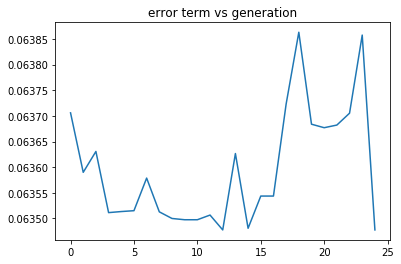

In [28]:
import matplotlib.pyplot as plt
#bestList.append(final[2:])
plt.plot(bestList)
plt.title("error term vs generation")

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

model = svm.SVR(kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accNoGA = model.score(X_test, y_test)

print(accNoGA)

0.8498331726986796


In [30]:
print("Accuracy improvement with GA: ", accWithGA-accNoGA)

Accuracy improvement with GA:  0.0947413052183752
